# What's going on accualy?

In this notebook we will: <br/> 
a) Load photo with size 4080x3072 <br/> 
b) Split it in chuncks <br/> 
c) Reduce chunk size to 96x96 px , because model is trained for 96x96 input<br/>
d) Predict if chunk cosist cancer cells  <br/>
e) Plot subplots with labeled chunkcks <br/>
f) Plot subplots with labeled chunkcks with predict explained map

# 1) Load all important code

In [7]:
import warnings
warnings.filterwarnings('ignore')

import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os 
import IPython
import imgaug as ia
from glob import glob 
import tensorflow as tf
tf.get_logger().setLevel('INFO')
import keras 
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization,GlobalAveragePooling2D
from keras.layers import LeakyReLU,Concatenate,GlobalMaxPooling2D
from keras.layers import Dense, Dropout, Flatten, Input,BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from keras.models import Model
from keras.callbacks import *
from keras import backend as K 
from keras.applications.nasnet import NASNetMobile, NASNetLarge, preprocess_input
from keras.losses import binary_crossentropy
from keras.optimizers import Adam,SGD
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import lime
from lime import lime_image
from tqdm import tqdm
from skimage.segmentation import mark_boundaries


def crop_part(photo_abs_path, crop_dim=(0,0),crop_start_x = 0, crop_start_y=0):
    ''' Crop part of image with given dim, from some starting point for given x and y
    INPUT
    photo_abs_path = photo absolute path
    crop_dim = dim for output image
    crop_start_x = x cord for cut start
    crop_start_y = y cord for cut start
    
    OUTPUT
    cropped_image - array with image
    out_of_image - 0 if its ok,  1 if cut is on right border ,  2 if is too high
    '''
    image_to_crop = cv2.imread(image_path)
    height, width, channel = image_to_crop.shape
    
    if height < crop_dim[1]+crop_start_y and width < crop_dim[0]+crop_start_x:
        cropped_image = image_to_crop[height-crop_dim[1]:height,width-crop_dim[0]:width,:]
        out_of_image = 3
      
    elif width < crop_dim[0]+crop_start_x:
        cropped_image = image_to_crop[crop_start_y:crop_start_y+crop_dim[0],width-crop_dim[0]:width,:]
        out_of_image = 1
        
    elif height < crop_dim[1]+crop_start_y:
        cropped_image = image_to_crop[height-crop_dim[1]:height,crop_start_x:crop_start_x+crop_dim[1],:]
        out_of_image = 2

    else:
        cropped_image = image_to_crop[crop_start_y:crop_start_y+crop_dim[0],crop_start_x:crop_start_x+crop_dim[1],:]
        out_of_image = 0
    return cropped_image,out_of_image



def cropper(photo_abs_path, crop_dim=(400,400),start_row=0,one_row=False):
    image_to_crop = cv2.imread(image_path) 
    height , width, channel = image_to_crop.shape
    x_crop = 0
    y_crop = 0
    stop_check_2 = 0
    place_list = []
    images_list = []
    stop_value = 0
    images_dataframe = pd.DataFrame() 

  
    for i in range(start_row,int(np.ceil(height/crop_dim[1]))):
        #Iterating by height
        
        if one_row == True:
            y_crop = crop_dim[1]*start_row
            if stop_value == 1:
                return images_list, place_list 
            else:
                stop_value = 1
            
            
        for j in range(0,int(np.ceil(width/crop_dim[0]))+1):
            #Iterating by width

        
            cropped_image,out = crop_part(photo_abs_path= image_path, 
                                        crop_dim=crop_dim,
                                        crop_start_x = x_crop,   
                                        crop_start_y= y_crop )

            
            images_list.append(cropped_image)
            place_list.append([i,j])
            x_crop += crop_dim[0]

            if out == 1:
                x_crop = 0
                y_crop += crop_dim[1]

                break
            
            if stop_check_2 != 1: 
                if out == 2:
                    x_crop = crop_dim[1]
                    stop_check_2 = 1
                    
            
                    
    return images_list, place_list






input_shape = (96, 96, 3) # Defining image size, can be different if any other model is given
output_shape = 1 # Output shape required in binary classification
learning_rate = 0.0001 # Hiperparameter to define speed of learning.

def create_model(): 
    ''' Function makes an object which contain model classifier 
        using Keras python library
        
         Parameters:
        -----------
         Function does not require any specific argument if 
         proper global variables are given.
         
         Returns:
       ------------ 
         Object that consist of model classifier to classify 
         the input data
    '''
    input_tensor = Input(shape=input_shape)
    base_model = NASNetMobile(include_top=False, input_tensor=input_tensor)
    x = base_model(input_tensor) 
    out1 = GlobalMaxPooling2D()(x)
    out2 = GlobalAveragePooling2D()(x)
    out3 = Flatten()(x)
    out = Concatenate(axis=-1)([out1, out2, out3]) 
    out = Dropout(.5)(out) 
    out = Dense(output_shape, activation='sigmoid')(out)
    model = Model(input_tensor, out)
    model.compile(optimizer = Adam(learning_rate), loss=binary_crossentropy, metrics=['acc'])
    # If you want to add cyclical learning rate is better to use SGD optimizer 
    #model.compile(optimizer=SGD(learning_rate), loss=binary_crossentropy,metrics =['acc'])
    return model 
                

model = create_model() # Creating Model

print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
NASNet (Model)                  (None, 3, 3, 1056)   4269716     input_3[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d_3 (GlobalM (None, 1056)         0           NASNet[1][0]                     
__________________________________________________________________________________________________
global_average_pooling2d_3 (Glo (None, 1056)         0           NASNet[1][0]                     
__________________________________________________________________________________________________
flatten_3 

 # 2) Load model

In [8]:
model = tf.keras.models.load_model(r'C:\Users\lancernik\1GitProjects\Chunker\data\model_pierwszy_adam.h5')

# 3) Predict and plot

6 7 42


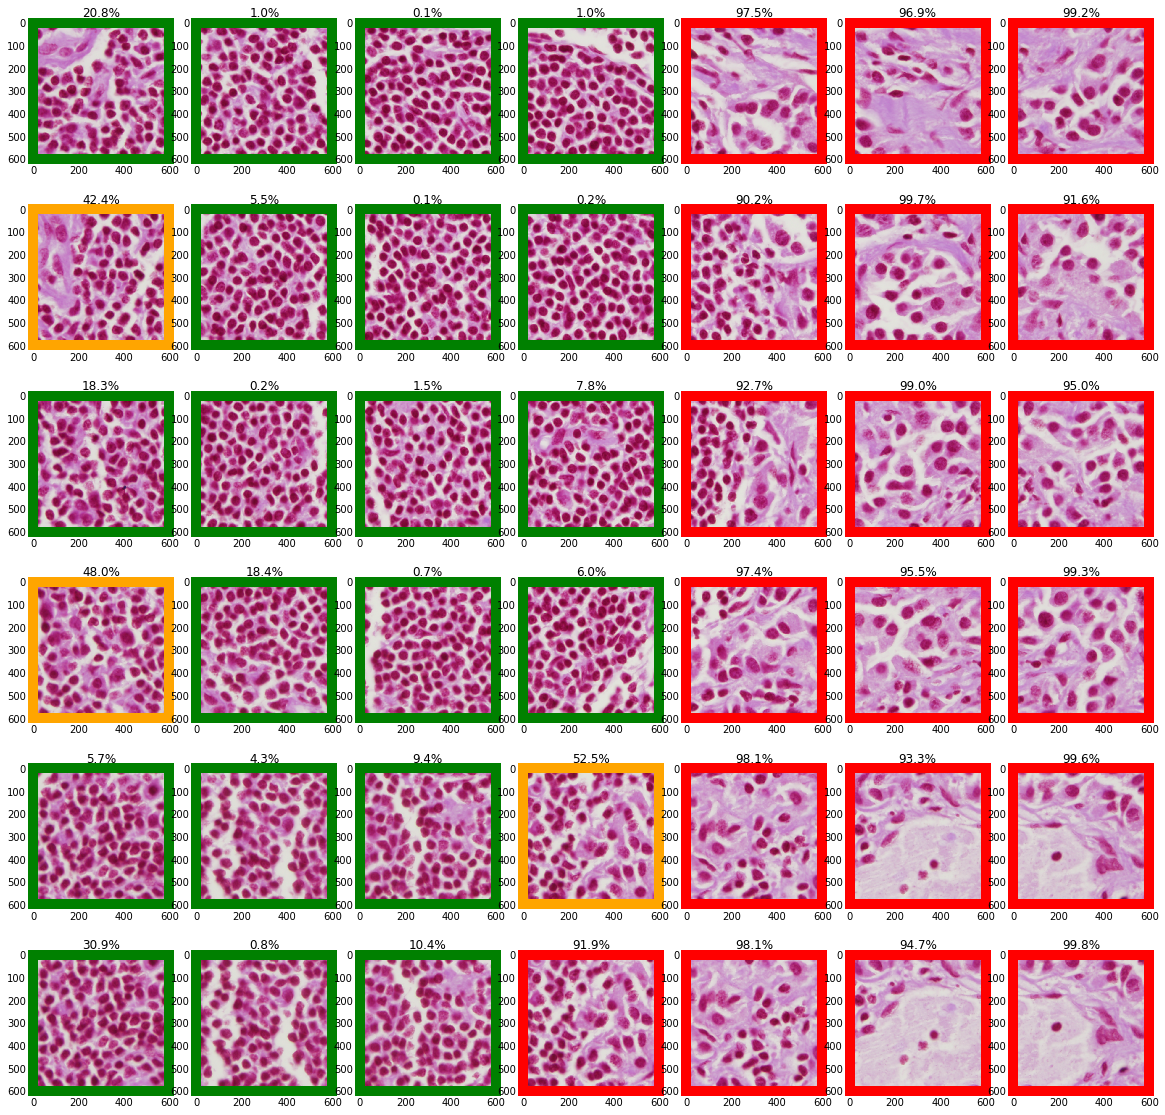

In [9]:
#Use own settinings here 
image_path = r"C:\Users\lancernik\1GitProjects\Chunker\data\cmuj\pointrLN+.tif"
chunk_size = (600,600)          
#Use own settinings here 





# Don't touch code bellow line in this cel 
#--------------------------------------------------------------------------------------------------------------------------
#Load and chunk photo
images_list,place_list = cropper(image_path,crop_dim=(chunk_size))

#Make predictions
pred = []
for i in range(0,len(images_list)):
    
    image = cv2.resize(images_list[i], (96,96))
    #image = image.resize((96, 96), Image.ANTIALIAS)
    image = preprocess_input(image)
    image = image.reshape(1,96,96,3)
    pred.append(model.predict(image).item((0,0)))
    

#Create plot
plot_rows = place_list[-1][0]+1
plot_columns = place_list[-1][1]
PlotCount = plot_rows*plot_columns
print(plot_rows,plot_columns,PlotCount)


plt.figure(figsize=(20,20))
for i in range(1, PlotCount+1):
    if pred[i-1]<0.4:
        plt.rc('axes',edgecolor='g', lw=10)
    elif pred[i-1]<0.6:
        plt.rc('axes',edgecolor='orange', lw=10)
    else:
        plt.rc('axes',edgecolor='r', lw=10)
    plt.subplot(plot_rows, plot_columns, i).set_title('{}%'.format(round(pred[i-1]*100,1)))
    plt.imshow(images_list[i-1])
    

6 7 42


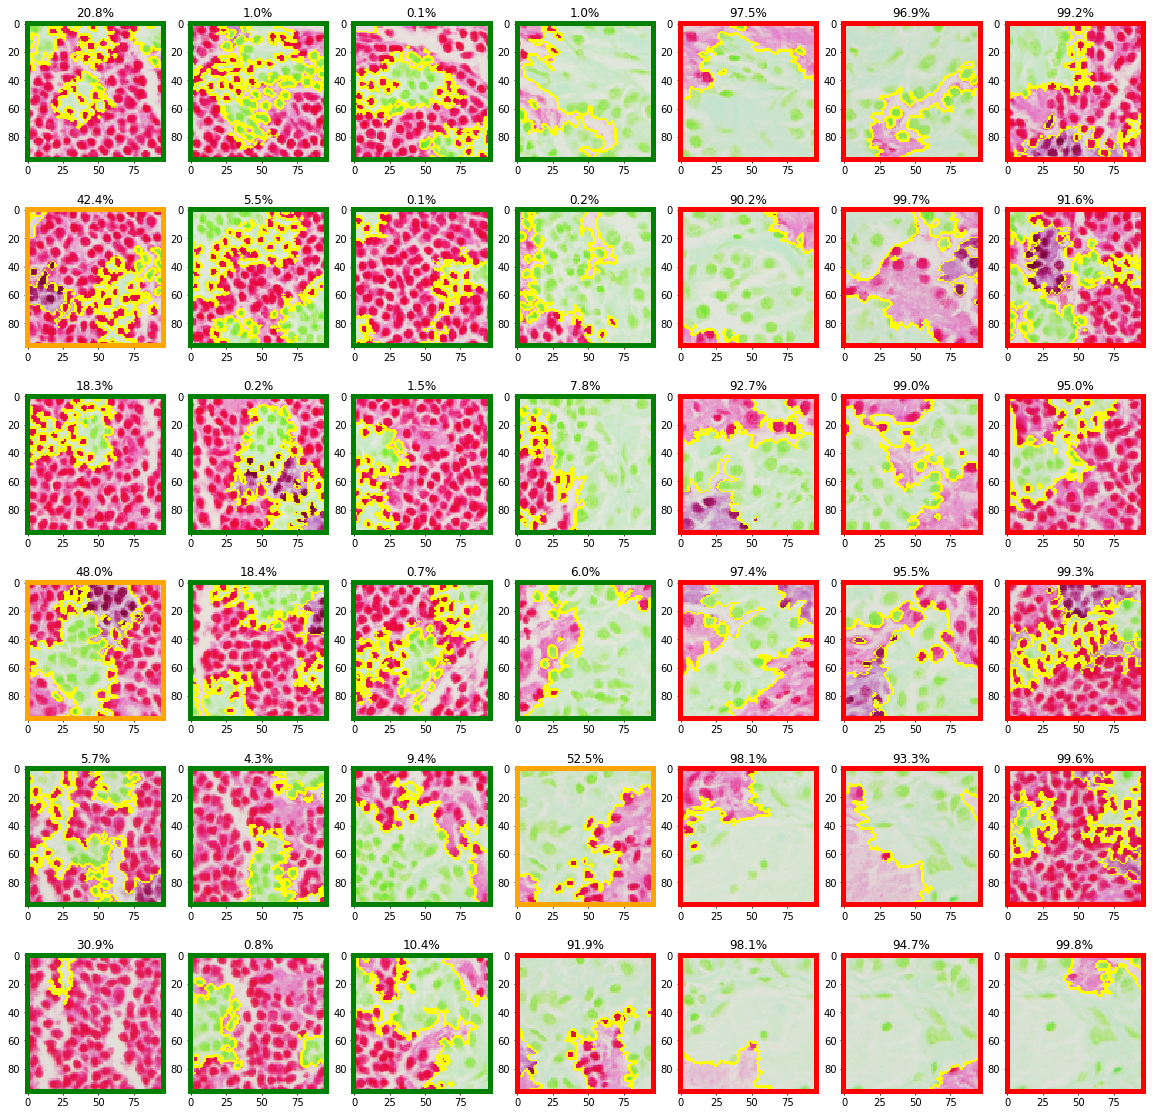

In [10]:
#Use own settinings here 
image_path = r"C:\Users\lancernik\1GitProjects\Chunker\data\cmuj\pointrLN+.tif"
chunk_size = (600,600)          
#Use own settinings here 







# Don't touch code bellow line in this cel 
#--------------------------------------------------------------------------------------------------------------------------
explainer = lime.lime_image.LimeImageExplainer()


#Load and chunk photo
images_list,place_list = cropper(image_path,crop_dim=(chunk_size))



image = cv2.resize(images_list[i], (96,96))
image = preprocess_input(image)

'''
explanation = explainer.explain_instance(np.array(image), model.predict, top_labels=50, hide_color=0, num_samples=1500)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=20, hide_rest=False)
plt.figure()
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
'''


#Make predictions
pred = []
for i in range(0,len(images_list)):
    
    image = cv2.resize(images_list[i], (96,96))
    image = preprocess_input(image)
    image = image.reshape(1,96,96,3)
    pred.append(model.predict(image).item((0,0)))
       

#Create plot
plot_rows = place_list[-1][0]+1
plot_columns = place_list[-1][1]
PlotCount = plot_rows*plot_columns
print(plot_rows,plot_columns,PlotCount)


plt.figure(figsize=(20,20))
for i in range(1, PlotCount+1):
    if pred[i-1]<0.4:
        plt.rc('axes',edgecolor='g', lw=5)
    elif pred[i-1]<0.6:
        plt.rc('axes',edgecolor='orange', lw=5)
    else:
        plt.rc('axes',edgecolor='r', lw=5)
        
    
    image = images_list[i-1]
    image = cv2.resize(images_list[i], (96,96))
    image = preprocess_input(image)
    explanation = explainer.explain_instance(np.array(image), model.predict, top_labels=10, hide_color=0, num_samples=50)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
    
    plt.subplot(plot_rows, plot_columns, i).set_title('{}%'.format(round(pred[i-1]*100,1)))
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))